#### GTI770 - TP4

In [113]:
%matplotlib inline   
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import graphviz
import decimal
import pandas as pd
from openpyxl import load_workbook
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [114]:
#Utility methods
def SplitVectorData_Holdout(primitives_vector, train_portion):
    
    size = len(primitives_vector)
    subsize = len(primitives_vector[0])
    
    val_portion = (1 - train_portion) / 2
    test_portion = (1 - train_portion) / 2

    nbTrain = int(size * train_portion)
    nbVal = int(size * val_portion)
    nbTest = int(size * test_portion)

    array_train = np.zeros((nbTrain, subsize), dtype=np.float64)
    array_val = np.zeros((nbVal, subsize), dtype=np.float64)
    array_test = np.zeros((nbTest, subsize), dtype=np.float64)

    array_train = primitives_vector[:nbTrain]
    array_val = primitives_vector[nbTrain : nbTrain + nbVal]
    array_test = primitives_vector[-nbTest:]
    return array_train, array_val, array_test

def SplitLabels_Holdout(primitives_vector, train_portion):
    
    size = len(primitives_vector)
    subsize = 1
    
    val_portion = (1 - train_portion) / 2
    test_portion = (1 - train_portion) / 2

    nbTrain = int(size * train_portion)
    nbVal = int(size * val_portion)
    nbTest = int(size * test_portion)

    array_train = np.zeros((nbTrain, subsize), dtype=np.float64)
    array_val = np.zeros((nbVal, subsize), dtype=np.float64)
    array_test = np.zeros((nbTest, subsize), dtype=np.float64)

    array_train = primitives_vector[:nbTrain]
    array_val = primitives_vector[nbTrain : nbTrain + nbVal]
    array_test = primitives_vector[-nbTest:]
    return array_train, array_val, array_test

def LabelsStrToInt(array):
    return encoder.transform(array)

def LabelsIntToStr(array):
    return encoder.inverse_transform(array)

# ----- For debug -----
#Filter_train, Filter_val, Filter_test = SplitVectorDataTrainValTest(Filter, 0.6)
#print(len(Filter_train))
#print(len(Filter_val))
#print(len(Filter_test))
#print(len(Filter))
#----------------------

In [115]:
#Transforms and Models generation methods

def NormalizeData(data):
    return MinMaxScaler().fit_transform(data)

def GenerateScoresFromModel(x, y, chosen_model):
    
    X_train, X_val, X_test = SplitVectorData_Holdout(x, 0.8)
    Y_train, Y_val, Y_test = SplitLabels_Holdout(y, 0.8)
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    
    validations = [[Y_train, prediction_train], [Y_val, prediction_val], [Y_test, prediction_test]]
    
    return GenerateScores(validations)

def GenerateCombination(x, y, chosen_model):
    
    X_train, X_val, X_test = SplitVectorData_Holdout(x, 0.8)
    Y_train, Y_val, Y_test = SplitLabels_Holdout(y, 0.8)
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    
    validations = [[Y_train, prediction_train], [Y_val, prediction_val], [Y_test, prediction_test]]
    
    cnf_matrix = confusion_matrix(Y_test, prediction_test)
    
    acc, f1 = GenerateScores(validations)
    
    return acc, f1, cnf_matrix, model

def GeneratePredictionFromUntagged(x, trained_model):
    model = trained_model
    prediction = model.predict(x)
    return prediction


In [116]:
#display methods
def GenerateScores(array):
    AccScores = np.zeros(len(array), dtype=float)
    F1Scores = np.zeros(len(array), dtype=float)

    for i in range(0, len(array)):
        AccScores[i] = accuracy_score(array[i][0], array[i][1])
        F1Scores[i] = f1_score(array[i][0], array[i][1], average='weighted', labels=np.unique(array[i][1]))
    
    return AccScores, F1Scores

#Extraction de primitive
def TracePlot(array_acc_X, array_acc_Y, array_f1_X, array_f1_Y, titre, titre_x, titre_y):        
    
    plt.plot(array_acc_X, array_acc_Y, 'ro')
    plt.plot(array_f1_X, array_f1_Y, 'g*')
    plt.xlabel(titre_x)
    plt.ylabel(titre_y)
    plt.legend(['Accuracy Score','F1 Score'])
    plt.title(titre)
    plt.grid(True)
    plt.show()

In [117]:
#model creations methods
def DecisionTree_model(depth):
    return tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_leaf=1)

def CreateKNNModel(k, weight):
    return KNeighborsClassifier(n_neighbors=k, weights=weight)

def RandomForest_model(nb_estim, depth, min_sample):
    return RandomForestClassifier(n_estimators=nb_estim, max_depth=depth, min_samples_split=min_sample, random_state=0, criterion='entropy', n_jobs=3)

def svm_model(C, gamma, name):
    model = SVC(C=C, gamma=gamma, kernel=name)
    return model

def AdaBoost_model(depth, nb_estim, lr):
    model = AdaBoostClassifier(base_estimator = DecisionTree_model(depth), n_estimators=nb_estim, learning_rate=lr, algorithm='SAMME.R', random_state=None)
    return model

def CNN_model(layers, perceptrons, epochs, learnRate):
    
    hiddenLayers = np.zeros((layers,), dtype=int)
    for i in range(0, len(hiddenLayers)):
        hiddenLayers[i] = perceptrons
    
    #Create model
    model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=hiddenLayers, learning_rate_init=learnRate, 
                          max_iter=epochs, random_state=1)
    
    return model

def Ensemble_model():
    model = VotingClassifier(estimators = [ ('DT', RandomForest_model(25, 10, 20)),
                                           ('AB', AdaBoost_model(15, 25, 1.0)), 
                                           ('SVM', svm_model(10.0, 10.0, 'rbf')),
                                           ('CNN', CNN_model(3, 120, 60, 0.001))], 
                                            voting = 'hard', n_jobs=3) 
    return model

In [118]:
def svm(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    acc, f1 = SVM_rbf(X_train, Y_train, X_val, Y_val, X_test, Y_test, 10.0, 10.0)
    return acc

def SVM_linear(X_train, Y_train, X_val, Y_val, X_test, Y_test, C, gamma):   
    print("svm_linear with C = "+str(C)+" and gamma = "+str(gamma))
    clf = SVC(C=C, gamma=gamma, kernel='linear')
    clf.fit(X_train, np.ravel(Y_train))
    
    print("Start predictions...")
    pred_train = clf.predict(X_train)
    pred_val = clf.predict(X_val)
    pred_test = clf.predict(X_test)
    
    validations = [[Y_train, pred_train], [Y_val, pred_val], [Y_test, pred_test]]
    a1, f1 = GenerateScores(validations)
    print("acc = " + str(a1) + ", f1 = " + str(f1))
    return GenerateScores(validations)

def SVM_rbf(X_train, Y_train, X_val, Y_val, X_test, Y_test, C, gamma):   
    clf = SVC(C=C, gamma=gamma, kernel='rbf')
    clf.fit(X_train, np.ravel(Y_train))
    
    pred_train = clf.predict(X_train)
    pred_val = clf.predict(X_val)
    pred_test = clf.predict(X_test)
    
    validations = [[Y_train, pred_train], [Y_val, pred_val], [Y_test, pred_test]]
    a1, f1 = GenerateScores(validations)

    return GenerateScores(validations)
    

In [119]:
def AddAccAndF1ToExcel(name, acc, f1, c_acc, c_f1):
    acc_new = pd.DataFrame({'acc': acc})
    f1_new = pd.DataFrame({'f1': f1})
    wb = load_workbook(name)

    ws = wb['Feuil1']

    for index, row in acc_new.iterrows():
        cell =  c_acc+'%d'  % (index + 2)
        ws[cell] = row[0]
        
    for index, row in f1_new.iterrows():
        cell = c_f1 + '%d'  % (index + 2)
        ws[cell] = row[0]

    wb.save(name)


    return pd.read_excel(name, index_col=0)

#svm = AddAccAndF1ToExcel('svm.xlsx', acc_svm, f1_svm, 'D', 'E')
#rn_holdout = AddAccAndF1ToExcel('rn_holdout.xlsx', acc_neurone_holdout, f1_neurone_holdout, 'F', 'G')

# For Debugging
#print(acc_svm)
#print(f1_svm)
#print(acc_neurone_holdout)
#print(f1_neurone_holdout)

In [120]:
def plot_confusion_matrix(cm, classes=Labels, title='Matrice de confusion', cmap=plt.cm.Blues):
    #print(cm)
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Musique

In [121]:
Labels = ['BIG_BAND', 'BLUES_CONTEMPORARY', 'COUNTRY_TRADITIONAL', 'DANCE', 'ELECTRONICA', 'EXPERIMENTAL',
          'FOLK_INTERNATIONAL', 'GOSPEL', 'GRUNGE_EMO', 'HIP_HOP_RAP', 'JAZZ_CLASSIC', 'METAL_ALTERNATIVE', 
          'METAL_DEATH', 'METAL_HEAVY', 'POP_CONTEMPORARY', 'POP_INDIE', 'POP_LATIN', 'PUNK', 'REGGAE','RNB_SOUL',
          'ROCK_ALTERNATIVE', 'ROCK_COLLEGE', 'ROCK_CONTEMPORARY', 'ROCK_HARD', 'ROCK_NEO_PSYCHEDELIA']

encoder = LabelEncoder()
encoder.fit(Labels)

def GetDataSet(name, nb, length):
    fid = open(os.path.normpath('music/tagged_feature_sets/' + name + '/' + name + '.csv'), 'r') 

    ids = np.zeros((nb, 2), dtype=np.object)
    primitives = np.zeros((nb, length), dtype=np.float64)
    labels = np.zeros((nb, 1), dtype=np.object)

    count = 0
    
    for line in fid:
        element = line.rstrip('\n').split(',')
        
        ids[count] = element[:2]
        primitives[count] = element[2:-1]
        labels[count] = element[-1:]

        count += 1
        if count >= nb:
            break

    fid.close()
    
    normalizedPrimitives = NormalizeData(primitives)

    return ids, normalizedPrimitives, LabelsStrToInt(np.ravel(labels))

def GetUntaggedDataSet(name, nb, length):
    fid = open(os.path.normpath('music/untagged_feature_sets/' + name + '/' + name + '.csv'), 'r') 

    ids = np.zeros((nb, 2), dtype=np.object)
    primitives = np.zeros((nb, length), dtype=np.float64)

    count = 0
    
    for line in fid:
        element = line.rstrip('\n').split(',')
        
        ids[count] = element[:2]
        primitives[count] = element[2:-1]

        count += 1
        if count >= nb:
            break

    fid.close()
    
    normalizedPrimitives = NormalizeData(primitives)

    return ids, normalizedPrimitives

# ----- For debug -----
#print(count_smooth)
#print(count_spiral)
#print(count)
#print(Galaxies)
#----------------------

In [122]:
nbData = 50000

# id10, x10, y10 = GetDataSet('msd-mvd_dev', nbData, 420)
# id9, x9, y9 = GetDataSet('msd-trh_dev', nbData, 420)
# id8, x8, y8 = GetDataSet('msd-ssd_dev', nbData, 168)
ids, x, y = GetDataSet('msd-marsyas_dev_new', nbData, 124)
id6, x6, y6 = GetDataSet('msd-jmirderivatives_dev', nbData, 96)
id5, x5, y5 = GetDataSet('msd-rh_dev_new', nbData, 60)
#id4, x4, y4 = GetDataSet('msd-jmirmfccs_dev', nbData, 26)
# id3, x3, y3 = GetDataSet('msd-jmirlpc_dev', nbData, 20)
# id2, x2, y2 = GetDataSet('msd-jmirspectral_dev', nbData, 16)
# id1, x1, y1 = GetDataSet('msd-jmirmoments_dev', nbData, 10)

#----------For Debug-------------
# print(id1[0])
# print(x1[0])
# print(y1[0])
#--------------------------------

In [102]:
acc_NB, f1_NB = GenerateScoresFromModel(x6, y6, GaussianNB())

In [46]:
acc_DT, f1_DT = GenerateScoresFromModel(x5, y5, DecisionTree_model(15))

In [36]:
acc_SVM, f1_SVM = GenerateScoresFromModel(x, y, svm_model(10.0, 10.0, 'rbf'))

svm_rbf with C = 10.0 and gamma = 10.0
Start predictions...
acc = [0.364075   0.25025005 0.25485097], f1 = [0.34914461 0.22817566 0.23620963]


In [ ]:
acc_RF, f1_RF = GenerateScoresFromModel(x, y, RandomForest_model(25, 10, 20))

In [ ]:
acc_CNN, f1_CNN = GenerateScoresFromModel(x, y, CNN_model(3, 120, 60, 0.001))

In [108]:
acc_AB, f1_AB = GenerateScoresFromModel(x, y, AdaBoost_model(15, 50, 1.0))

TypeError: AdaBoostClassifier with algorithm='SAMME.R' requires that the weak learner supports the calculation of class probabilities with a predict_proba method.
Please change the base estimator or set algorithm='SAMME' instead.

In [ ]:
acc_VOTE, f1_VOTE, cm_VOTE, trainedModel = GenerateCombination(x, y, Ensemble_model())

In [ ]:
print("Bayes avec JMIR Derivatives, 96 features : ")
print("acc = " + str(acc_NB) + ", f1 = " + str(f1_NB) + "\n")

print("DecisionTree avec Rhythm Histogram, 60 features : ")
print("acc = " + str(acc_DT) + ", f1 = " + str(f1_DT) + "\n")

print("SVM avec MARSYAS , 124 features : ")
print("acc = " + str(acc_SVM) + ", f1 = " + str(f1_SVM) + "\n")

print("RandomForest avec MARSYAS , 124 features : ")
print("acc = " + str(acc_RF) + ", f1 = " + str(f1_RF) + "\n")

print("CNN avec MARSYAS , 124 features : ")
print("acc = " + str(acc_CNN) + ", f1 = " + str(f1_CNN) + "\n")

print("AdaBoost avec MARSYAS , 124 features : ")
print("acc = " + str(acc_AB) + ", f1 = " + str(f1_AB) + "\n")

print("VotingClassifier avec MARSYAS , 124 features : ")
print("acc = " + str(acc_VOTE) + ", f1 = " + str(f1_VOTE) + "\n")

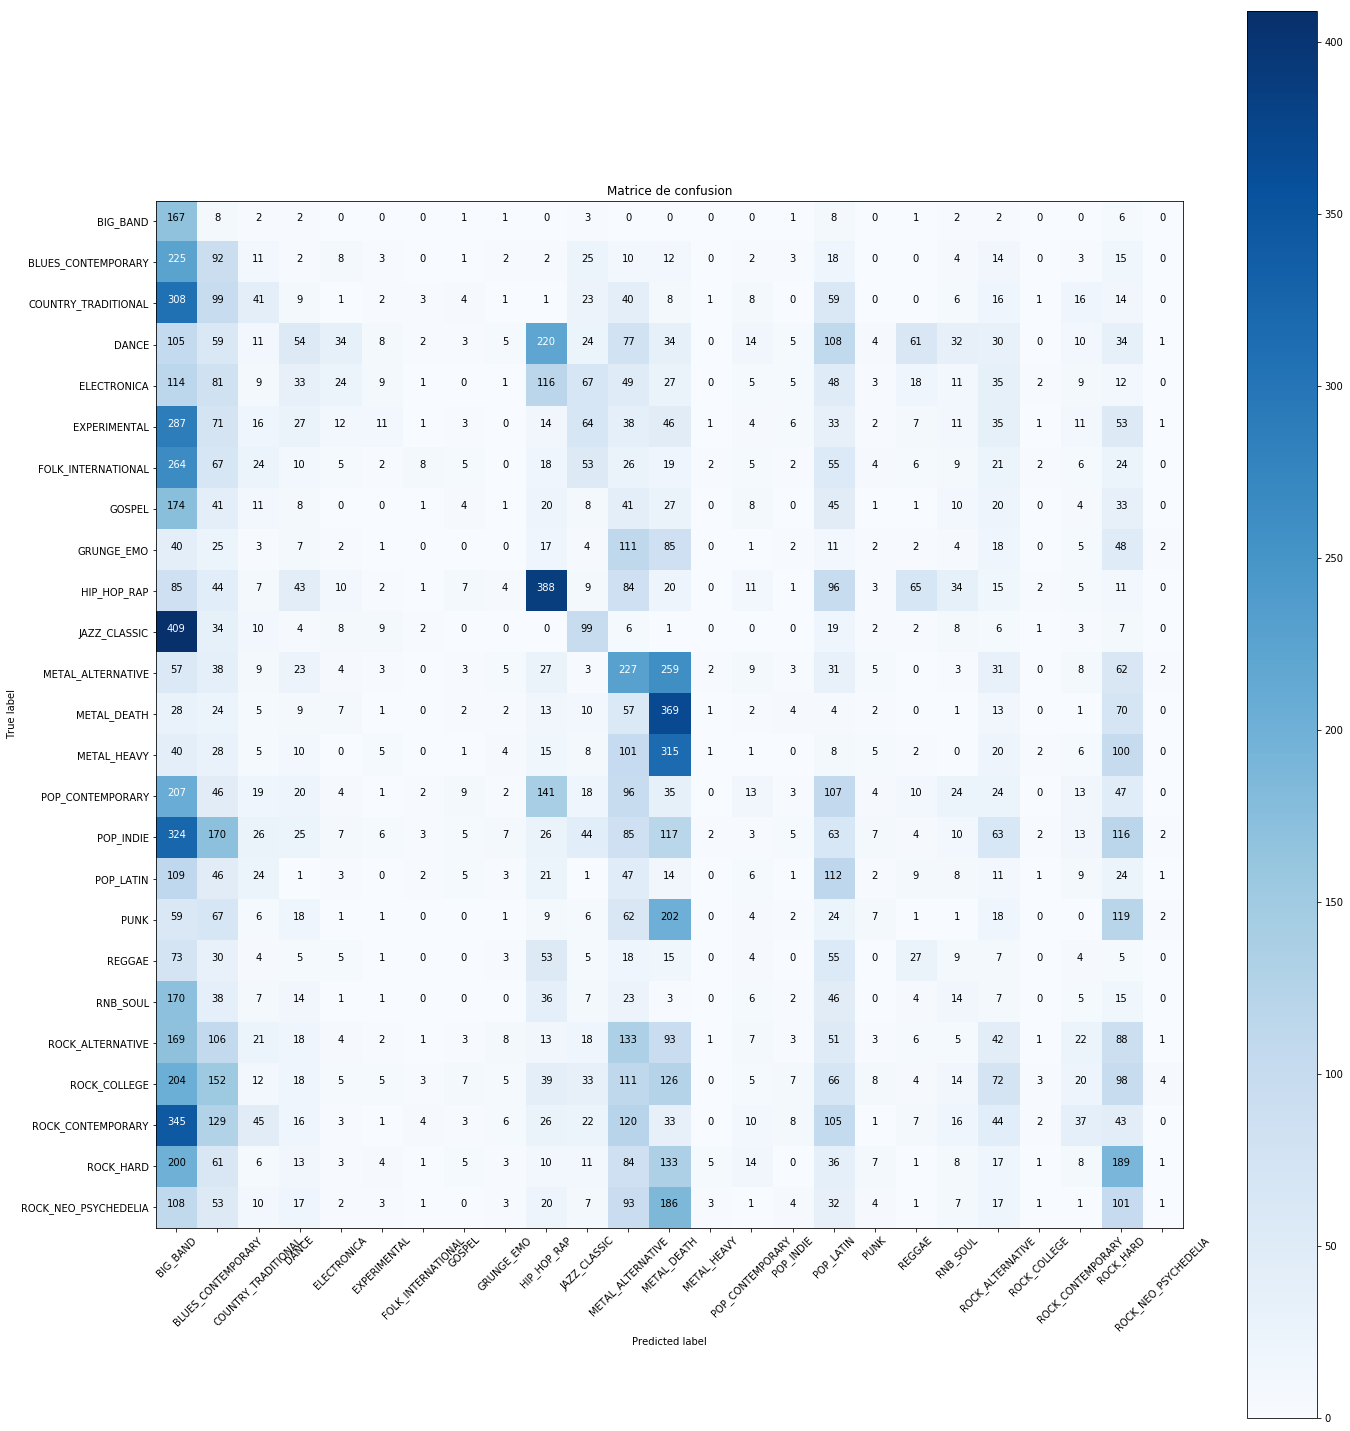

In [105]:
plot_confusion_matrix(cm_VOTE)

In [ ]:
#Generation des tags à partir du model entrainé.
ids_notag, x_notag = GetUntaggedDataSet('msd-marsyas_test_new_nolabels', 179555, 124)
pred_notag = GeneratePredictionFromUntagged(x_notag, trainedModel)
result = np.zeros((len(ids_notag), 2), dtype=object)

for i in range(0, len(ids_notag)):
    result[i][0] = ids_notag[i][1]
    result[i][1] = pred_notag[i]
    


# Rapport

**1- Avec les liens fournis en l’annexe de cet énoncé et avec vos trouvailles faites sur Internet par le biais de vos recherches personnelles, faites, à titre d’introduction, une revue de la littérature. Expliquez en quelques paragraphes comment nous réussissons aujourd’hui à classifier différents sons et pièces musicales automatiquement afin de bien comprendre le sujet sur lequel vous travaillez. **

**2- Quelle est la configuration (machine, matériel, versions logiciel) de votre environnement? Quelle a été votre approche de partitionnement des données? Quels ensembles de primitives avez-vous choisis? Quelle méthode de validation avez-vous utilisée afin de confectionner vos modèles? Quelles étapes supplémentaires avez-vous eu à effectuer en prétraitement (normalisation, balancement, réduction de dimensionnalité, etc.)? **

**3- Quels sont les trois modèles d’apprentissage que vous avez décidé d’étudier à titre de classificateur de base? Exprimez les raisons qui vous ont mené à un tel choix. Si vous avez décidé d’implémenter un réseau de neurones, décrivez la structure de votre modèle d’apprentissage par réseau de neurones. Ajoutez tous graphiques ou représentation pertinente afin de décrire votre modèle, par exemple, un graphe TensorBoard si applicable ou un texte descriptif. **

**4- Pour vos trois modèles, présentez les hyperparamètres d’apprentissage et les ensembles de données utilisées ayant menés à votre meilleur résultat de précision (accuracy) et F-measure. Comment ces classificateurs ont-ils performés sur cet ensemble de données ? Discutez des résultats. **

**5- Présentez la conception de votre solution finale au problème (votre solution reposant sur la théorie des ensembles). Présentez ici le diagramme nécessaire afin de présenter convenablement votre combinaison de modèles, les ensembles de primitives choisies ainsi que la stratégie de combinaison. Faites une discussion expliquant vos décisions de conception. Faites des liens avec l’implémentation et présentez le code clé de celle-ci. **

**6- Consignez dans un tableau les hyperparamètres finaux de vos modèles faisant partie de votre ensemble. Présentez le score de précision (accuracy) et F1 final de votre ensemble. Présentez une discussion faisant l’analyse des résultats de votre système final. Décrivez les problèmes et difficultés rencontrées. Décrivez les performances de votre ensemble et tentez d’expliquer ces résultats. **

**7. Formulez quelques pistes d’amélioration de la solution développée.**